In [1]:
!pip install openpyxl
!pip install xlrd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


# 1/ Nettoyage et modélisation des données élections

Récuperation des données sur les élections européennes de 2024 et 2019

In [2]:
url = "https://www.data.gouv.fr/api/1/datasets/r/2690a1ed-13fb-4164-a006-2878000bf4c1"
ee2024= pd.read_excel(url, sheet_name=0)
ee2024.head()

,Code département,Libellé département,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,% Exprimés/inscrits,% Exprimés/votants,...,% Voix/exprimés 37,Sièges 37,Numéro de panneau 38,Nuance liste 38,Libellé abrégé de liste 38,Libellé de liste 38,Voix 38,% Voix/inscrits 38,% Voix/exprimés 38,Sièges 38
0,01,Ain,449217,244260,"54,37%",204957,"45,63%",237523,"52,87%","97,24%",...,"0,03%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,4,"0,00%","0,00%",0
1,02,Aisne,373728,189750,"50,77%",183978,"49,23%",183689,"49,15%","96,81%",...,"0,03%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,9,"0,00%","0,00%",0
2,03,Allier,249428,138833,"55,66%",110595,"44,34%",131770,"52,83%","94,91%",...,"0,07%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,2,"0,00%","0,00%",0
3,04,Alpes-de-Haute-Provence,129172,74445,"57,63%",54727,"42,37%",72337,"56,00%","97,17%",...,"0,04%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
4,05,Hautes-Alpes,115059,66931,"58,17%",48128,"41,83%",64928,"56,43%","97,01%",...,"0,07%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,1,"0,00%","0,00%",0


In [5]:
url= "https://www.data.gouv.fr/api/1/datasets/r/4a26fcae-494b-4ef6-82bb-49fdd32c8159"
ee2019= pd.read_excel(url, sheet_name=0)
ee2019.head()


,Code du département,Libellé du département,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,...,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253
0,01,Ain,417781,209845,50.23,207936,49.77,4674,1.12,2.25,...,8,0.0,0.00,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,273,0.07,0.14
1,02,Aisne,371723,176251,47.41,195472,52.59,4970,1.34,2.54,...,10,0.0,0.01,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,49,0.01,0.03
2,03,Allier,248389,113300,45.61,135089,54.39,4331,1.74,3.21,...,2,0.0,0.00,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,16,0.01,0.01
3,04,Alpes-de-Haute-Provence,126239,56609,44.84,69630,55.16,1614,1.28,2.32,...,0,0.0,0.00,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,2,0.00,0.00
4,05,Hautes-Alpes,109697,49410,45.04,60287,54.96,1575,1.44,2.61,...,1,0.0,0.00,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,9,0.01,0.02


In [6]:
#on va separé les informations sur les départements et les informations sur les partis
ee2019_info = ee2019.iloc[:, :16]  
ee2019_parti= ee2019.iloc[:, 16:]

In [7]:
#On renomme les colonnes car il n'ya pas de noms de colonnes à par pour le LFI
noms_premieres_colonnes = ['N°Liste', 'Libellé Abrégé Liste', 'Libellé Etendu Liste','Nom Tête de Liste', 'Voix', '% Voix/Ins', '% Voix/Exp']

#On reporte les noms dans tout le tableau
nb_blocs = len(ee2019_parti.columns)//7  
nouveaux_noms = noms_premieres_colonnes * nb_blocs
ee2019_parti.columns = nouveaux_noms

In [9]:
#Sachant qu'il ya des colonnes inutiles, on va juste se concentrer sur le nom du parti et les infos sur le % de voix/exprimées
cols_par_parti = 7
cols_utiles = [1,6]   

#On selectionne les colonnes correspondantes pour chaque partie 
cols_a_garder = []
for i in range(0, ee2019_parti.shape[1], cols_par_parti):
    cols_a_garder.extend([i + j for j in cols_utiles])

ee2019_parti_n = ee2019_parti.iloc[:, cols_a_garder]


ee2019_parti_n.head()


,Libellé Abrégé Liste,% Voix/Exp,Libellé Abrégé Liste,% Voix/Exp,Libellé Abrégé Liste,% Voix/Exp,Libellé Abrégé Liste,% Voix/Exp,Libellé Abrégé Liste,% Voix/Exp,...,Libellé Abrégé Liste,% Voix/Exp,Libellé Abrégé Liste,% Voix/Exp,Libellé Abrégé Liste,% Voix/Exp,Libellé Abrégé Liste,% Voix/Exp,Libellé Abrégé Liste,% Voix/Exp
0,LA FRANCE INSOUMISE,4.81,UNE FRANCE ROYALE,0.01,LA LIGNE CLAIRE,0.00,PARTI PIRATE,0.07,RENAISSANCE,22.36,...,EUROPE ÉCOLOGIE,13.81,PARTI ANIMALISTE,2.05,LES OUBLIES DE L'EUROPE,0.23,UDLEF,0.00,EUROPE AU SERVICE PEUPLES,0.14
1,LA FRANCE INSOUMISE,6.28,UNE FRANCE ROYALE,0.01,LA LIGNE CLAIRE,0.00,PARTI PIRATE,0.05,RENAISSANCE,15.65,...,EUROPE ÉCOLOGIE,7.83,PARTI ANIMALISTE,2.58,LES OUBLIES DE L'EUROPE,0.24,UDLEF,0.01,EUROPE AU SERVICE PEUPLES,0.03
2,LA FRANCE INSOUMISE,6.71,UNE FRANCE ROYALE,0.02,LA LIGNE CLAIRE,0.01,PARTI PIRATE,0.03,RENAISSANCE,19.55,...,EUROPE ÉCOLOGIE,9.05,PARTI ANIMALISTE,2.38,LES OUBLIES DE L'EUROPE,0.30,UDLEF,0.00,EUROPE AU SERVICE PEUPLES,0.01
3,LA FRANCE INSOUMISE,8.08,UNE FRANCE ROYALE,0.01,LA LIGNE CLAIRE,0.00,PARTI PIRATE,0.17,RENAISSANCE,19.94,...,EUROPE ÉCOLOGIE,13.19,PARTI ANIMALISTE,2.21,LES OUBLIES DE L'EUROPE,0.28,UDLEF,0.00,EUROPE AU SERVICE PEUPLES,0.00
4,LA FRANCE INSOUMISE,6.73,UNE FRANCE ROYALE,0.01,LA LIGNE CLAIRE,0.00,PARTI PIRATE,0.06,RENAISSANCE,20.91,...,EUROPE ÉCOLOGIE,16.07,PARTI ANIMALISTE,2.07,LES OUBLIES DE L'EUROPE,0.33,UDLEF,0.00,EUROPE AU SERVICE PEUPLES,0.02


on va choisir les partis à garder: 2 methodes

In [10]:
#methode 1: on conserve les partis qui sont les + votés au niveaux national
cols_par_bloc=2
somme_voix_exp = []

for i in range(0, ee2019_parti_n.shape[1], cols_par_bloc):
    bloc = ee2019_parti_n.iloc[:, i:i+cols_par_bloc]
    nom_parti = bloc.iloc[0,0]
    total_parti = bloc.iloc[:, 1].sum()  # somme des %voix/exp pour un parti sur tous les departements
    somme_voix_exp.append((nom_parti, total_parti))

df_somme = pd.DataFrame(somme_voix_exp, columns=['Parti','total%'])
df_somme = df_somme.sort_values('total%', ascending=False)
top_parti = df_somme.iloc[:10,0]   #10 tops partis niveau national

print(top_parti)


22         PRENEZ LE POUVOIR
4                RENAISSANCE
29           EUROPE ÉCOLOGIE
28       UNION DROITE-CENTRE
0        LA FRANCE INSOUMISE
11            ENVIE D'EUROPE
14          DEBOUT LA FRANCE
20           LISTE CITOYENNE
10             LES EUROPÉENS
18    POUR L'EUROPE DES GENS
Name: Parti, dtype: object


In [11]:
#methode 2: on selectionne les 15 meilleurs partis par département et on ne garde que les 10 qui sont dans le top 15 de tous les departements. 

#on construit un tableau long avec voix et total exprimé par département
df= []

for i in range(0, ee2019_parti_n.shape[1], cols_par_bloc):
    bloc = ee2019_parti_n.iloc[:, i:i+cols_par_bloc]
    dfi = pd.DataFrame({
        "Dep": ee2019_parti_n.index +1 ,
        "Parti": bloc.iloc[:,0],            
        "V/Exp": bloc.iloc[:,1]     
    })
    df.append(dfi)
df_long = pd.concat(df)

#Top 15 partis par département
df_long_sort = df_long.sort_values(["Dep","V/Exp"], ascending=[True, False])
df_top15 = df_long_sort.groupby("Dep").head(15)

df_final = df_top15.pivot(index="Dep", columns="Parti", values="V/Exp")
df_final = df_final.fillna(0)              #0 quand le parti n'est pas dans le top 15 du departement

# on retire les colonnes où il y a au moins un 0
cols_a_gar= df_final.columns[(df_final != 0).all()]
df_final_filtre = df_final[cols_a_gar]

print(df_final_filtre.columns)

Index(['ENSEMBLE POUR LE FREXIT', 'ENVIE D'EUROPE', 'EUROPE ÉCOLOGIE',
       'LA FRANCE INSOUMISE', 'LES EUROPÉENS', 'LISTE CITOYENNE',
       'POUR L'EUROPE DES GENS', 'PRENEZ LE POUVOIR', 'RENAISSANCE',
       'UNION DROITE-CENTRE'],
      dtype='object', name='Parti')


Afin d’éviter d’inclure des partis faiblement, nous avons retenu uniquement les partis ayant obtenu le plus grand nombre de voix au niveau national. Cette approche privilégie partis réellement influents dans le scrutin et structurent le paysage politique (gauche, droite, centre).
Contrairement à une sélection fondée sur la seule présence dans tous les départements, qui aurait conservé des partis très faibles électoralement comme 'Ensemble pour le Frexit', ce choix permet de travailler sur un ensemble politiquement pertinent et statistiquement exploitable meme en n'incluant pas des parties qui sont majoritaires dans seulement un departement. 

In [12]:
#on garde les partis de la methode 1
from fonctions_nettoyage import selection_top_partis

ee2019_p_d, recap_2019 = selection_top_partis(ee2019_parti_n)

In [14]:
#on va mettre les noms des parties dans les colonnes
from fonctions_nettoyage import chang_col
ee2019_p_df=chang_col(ee2019_p_d)


Debut de l'analyse du tableau 2019

In [15]:
ee19p=pd.concat([ee2019_info.iloc[:,1] ,ee2019_p_df], axis=1)
ee19p

,Libellé du département,LA FRANCE INSOUMISE,RENAISSANCE,LES EUROPÉENS,ENVIE D'EUROPE,DEBOUT LA FRANCE,POUR L'EUROPE DES GENS,LISTE CITOYENNE,PRENEZ LE POUVOIR,UNION DROITE-CENTRE,EUROPE ÉCOLOGIE
0,Ain,4.81,22.36,2.80,5.12,4.26,1.61,2.63,24.31,10.64,13.81
1,Aisne,6.28,15.65,2.17,3.99,4.55,2.06,2.35,39.88,7.19,7.83
2,Allier,6.71,19.55,3.00,5.73,3.44,4.94,3.34,25.44,11.13,9.05
3,Alpes-de-Haute-Provence,8.08,19.94,1.70,5.11,3.93,3.22,2.83,27.16,6.51,13.19
4,Hautes-Alpes,6.73,20.91,2.26,5.79,3.93,2.46,3.05,23.49,7.68,16.07
...,...,...,...,...,...,...,...,...,...,...,...
102,Polynésie française,4.12,43.37,1.62,2.39,2.61,1.47,0.84,16.99,9.49,11.08
103,Saint-Pierre-et-Miquelon,11.90,18.27,1.92,10.97,0.00,1.53,5.37,24.02,6.98,14.50
104,Wallis et Futuna,7.69,37.13,5.47,4.93,0.00,1.98,3.73,13.33,19.20,0.30
105,Saint-Martin/Saint-Barthélemy,6.13,20.15,2.71,5.01,3.10,0.86,2.59,28.38,11.81,13.06


In [19]:
ee19p.describe()

,LA FRANCE INSOUMISE,RENAISSANCE,LES EUROPÉENS,ENVIE D'EUROPE,DEBOUT LA FRANCE,POUR L'EUROPE DES GENS,LISTE CITOYENNE,PRENEZ LE POUVOIR,UNION DROITE-CENTRE,EUROPE ÉCOLOGIE
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,6.640748,21.328598,2.508692,6.144206,3.580093,2.443551,3.199720,24.644393,8.887009,12.604393
std,2.213281,4.778285,0.718599,1.692694,1.003508,0.952475,0.864229,6.617375,2.587698,3.333147
min,3.070000,8.870000,0.820000,2.370000,0.000000,0.860000,0.840000,7.100000,3.360000,0.300000
25%,5.350000,18.830000,2.095000,5.030000,2.995000,1.835000,2.655000,20.835000,7.330000,10.590000
50%,6.280000,20.520000,2.460000,5.930000,3.650000,2.270000,3.120000,24.550000,8.310000,12.360000
75%,7.190000,22.880000,2.835000,7.020000,4.215000,3.010000,3.680000,28.850000,9.785000,14.300000
max,19.030000,43.370000,5.470000,10.970000,5.530000,5.830000,6.040000,46.120000,19.560000,22.860000


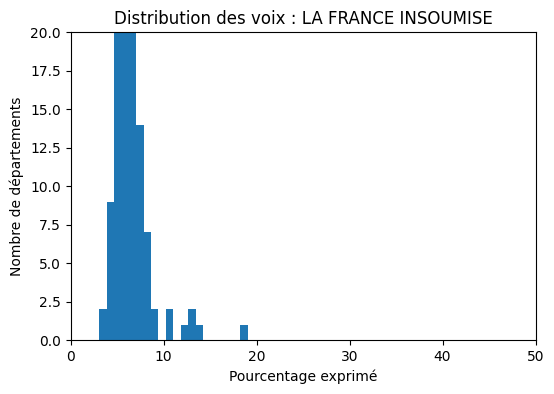

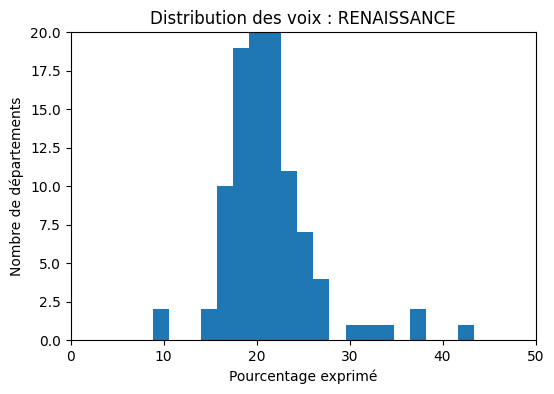

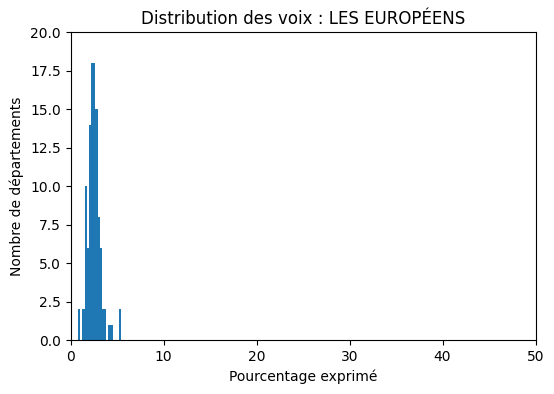

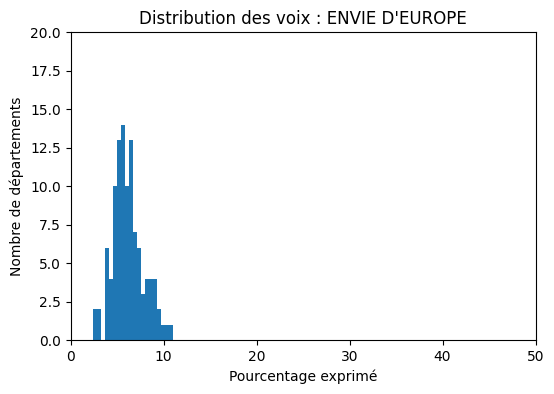

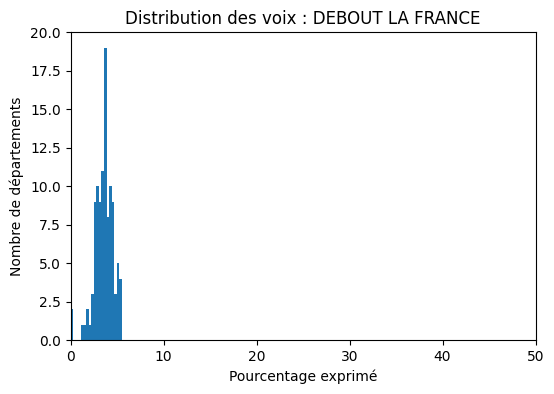

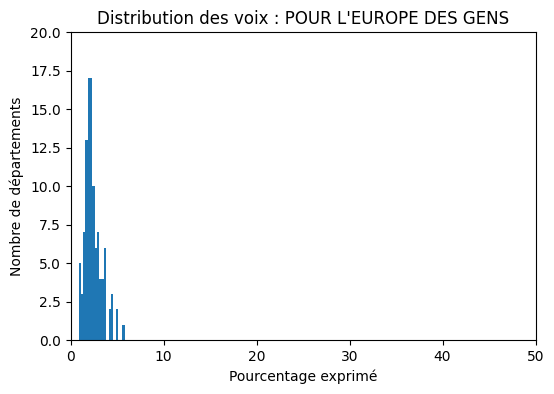

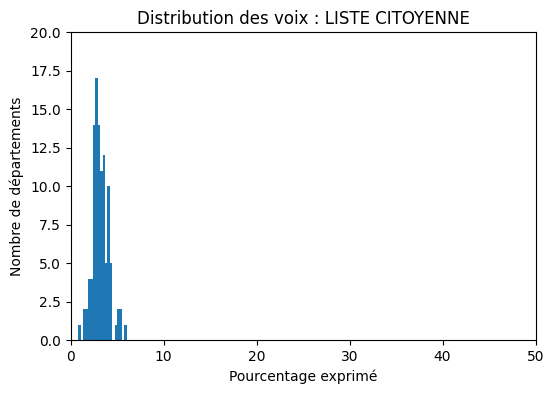

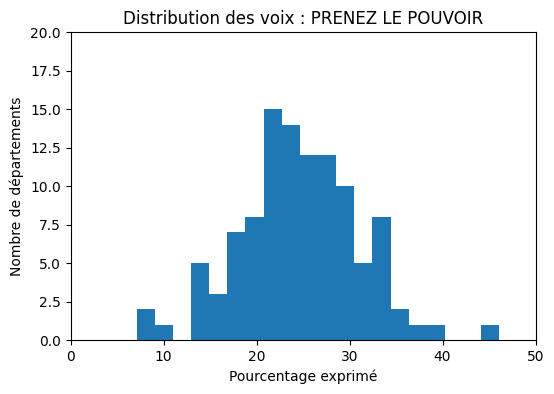

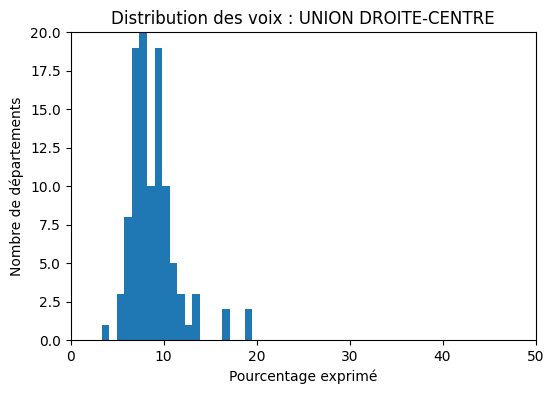

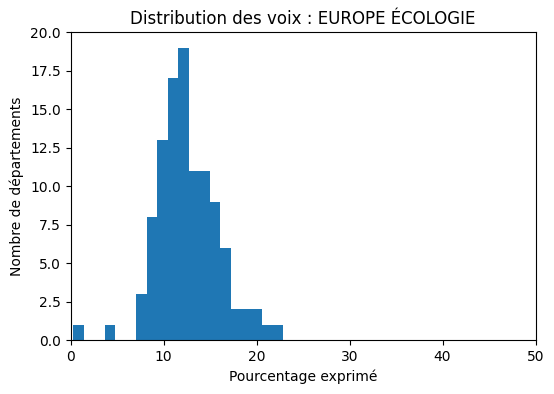

In [20]:
import matplotlib.pyplot as plt

for col in ee2019_p_df.columns:
    plt.figure(figsize=(6,4))
    plt.ylim(0,20)
    plt.xlim(0,50)
    plt.hist(ee2019_p_df[col], bins=20)
    plt.title(f"Distribution des voix : {col}")
    plt.xlabel("Pourcentage exprimé")
    plt.ylabel("Nombre de départements")
    plt.show()

La fonction describe et les histogrammes nous montrent une domination du parti 'PRENEZ LE POUVOIR' avec un moyenne de %voix/exp de 24.6 et un histogramme plus vers la droite et prenant des valeurs plus élevées que ceux des autres. Il est suivi de près par 'RENAISSANCE' qui a une moyenne à 21.3 et ' EUROPE ECOLOGIQUE' avec une moyenne de 12.6

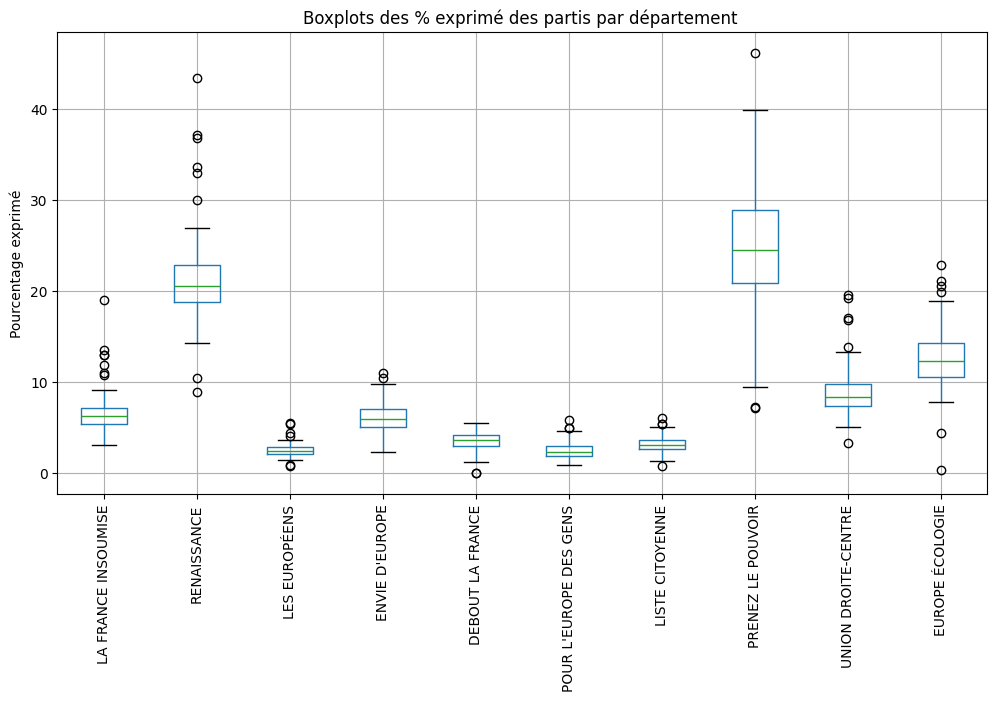

In [16]:
plt.figure(figsize=(12,6))
ee2019_p_df.boxplot(rot=90)
plt.title("Boxplots des % exprimé des partis par département ")
plt.ylabel("Pourcentage exprimé")
plt.show()


L'analyse des boîtes à moustaches révèle une hiérarchie électorale marquée, dominée par la liste 'PRENEZ LE POUVOIR' qui affiche la médiane la plus élevée (environ 25 %) ainsi qu'une forte disparité territoriale, comme en témoignent l'étirement de sa boîte et la présence d'un score exceptionnel dépassant les 45 %. Elle est suivie par 'RENAISSANCE', qui se stabilise autour de 20 % mais présente de nombreux points atypiques vers le haut, suggérant des bastions électoraux très spécifiques. À l'inverse, des formations comme 'LES EUROPÉENS' ou 'DEBOUT LA FRANCE' se caractérisent par une grande homogénéité et des scores uniformément bas, illustrés par des boîtes très compactes proches de l'axe des abscisses. Entre ces deux blocs, 'EUROPE ÉCOLOGIE' et l 'UNION DROITE-CENTRE' occupent une position intermédiaire avec une dispersion modérée, soulignant un paysage politique fragmenté où les écarts de performance entre les départements sont particulièrement prononcés pour les partis de tête.

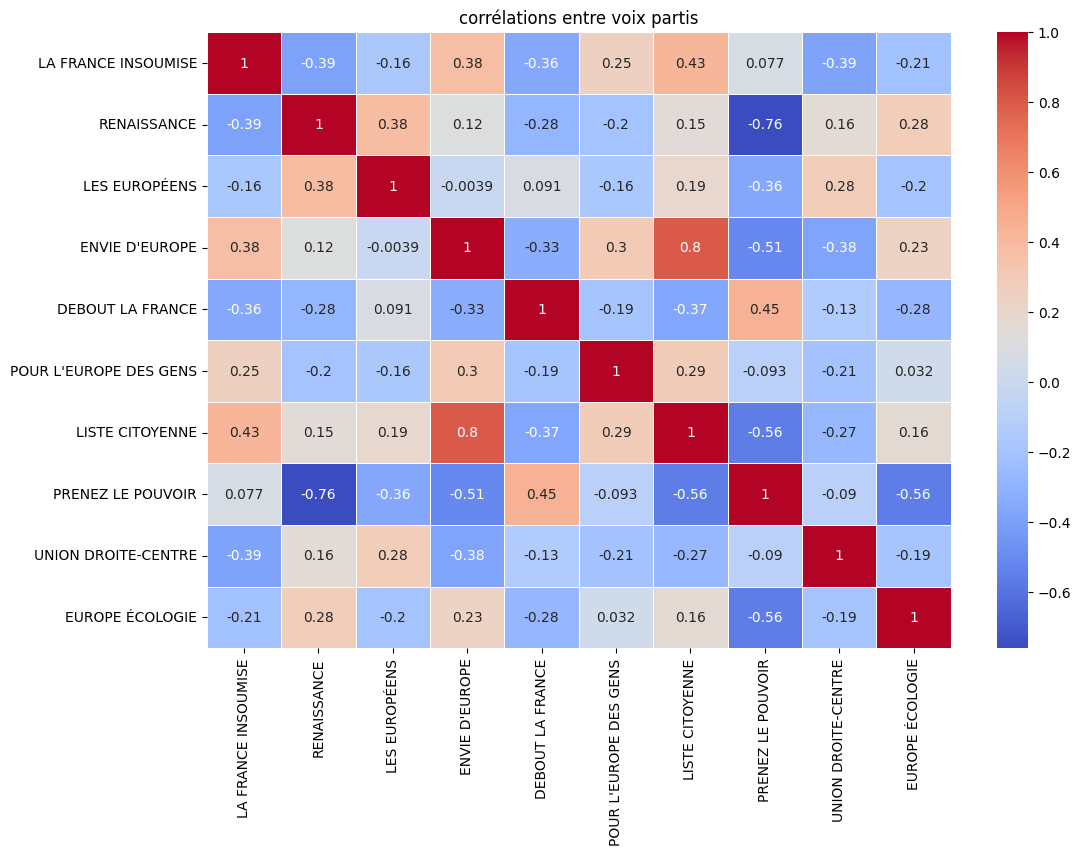

In [22]:
import seaborn as sns

cor = ee2019_p_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("corrélations entre voix partis")
plt.show()


Ce tableau de corrélation met en lumière une fracture de l'espace politique, structurée autour de trois dynamiques principales : une fusion électorale à gauche, une opposition frontale entre centres et extrêmes, et une proximité des blocs souverainistes. 
On observe d'abord une très forte cohésion au sein de la gauche, illustrée par la corrélation quasi parfaite entre Envie d'Europe et Liste Citoyenne (0,8), qui partagent les mêmes bases géographiques avec La France Insoumise. 
À l'inverse, le paysage est marqué par des antagonismes radicaux, notamment l'opposition majeure entre Renaissance et Prenez le Pouvoir (−0,76), confirmant que le vote macroniste et le vote RN s'excluent mutuellement sur le territoire. 
Enfin, le bloc de droite affiche une cohérence interne logique avec la corrélation positive entre Debout la France et Prenez le Pouvoir (0,45), tandis que ces deux listes s'opposent systématiquement aux autres partis.

In [17]:
#on va cree un tableau qui reuni les partis par bord politique
gauche= ["LISTE CITOYENNE","LA FRANCE INSOUMISE","POUR L'EUROPE DES GENS","EUROPE ÉCOLOGIE"]
droite= ["UNION DROITE-CENTRE","DEBOUT LA FRANCE","PRENEZ LE POUVOIR"]
centre=["RENAISSANCE","ENVIE D'EUROPE","LES EUROPÉENS"]
G= ee19p[gauche].sum(axis=1)
D=ee19p[droite].sum(axis=1)
C=ee19p[centre].sum(axis=1)
total_pd=G+D+C

bord_pol=pd.DataFrame({
    "Dep":ee19p.iloc[:,0],
    "G": G/total_pd,
    "C": C/total_pd,
    "D": D/total_pd,
}) 

voix_bpf= bord_pol.iloc[:100,:]
#on reduit a 100 car les autres tableaux n'incluent pas les collectivites d'outre mer


Le regroupage des partis par bord politique a été effectué par ChatGP en prenant en compte le positionnement ideologique auto-déclaré, les familles politiques européennes et les programmes des differents partis.

In [18]:
voix_bpf

,Dep,G,C,D
0,Ain,0.247537,0.327883,0.424580
1,Aisne,0.201414,0.237194,0.561392
2,Allier,0.260370,0.306293,0.433337
3,Alpes-de-Haute-Provence,0.298026,0.291808,0.410167
4,Hautes-Alpes,0.306485,0.313522,0.379994
...,...,...,...,...
95,Val-d'Oise,0.306659,0.352830,0.340511
96,Guadeloupe,0.322652,0.321985,0.355363
97,Martinique,0.360188,0.343113,0.296700
98,Guyane,0.391365,0.258410,0.350225


In [ ]:
voix_bpf.to_csv("ee_bp19.csv",index=False)

In [29]:
df1 = pd.read_csv("ee_bp19.csv")

On va maintenant déterminer des clusters de regions et modéliser l'appartenance aux differents bords politique des regions.

On va utiliser la methode du coude pour déterminer combien de groupes (clusters) il est pertinent de former avec k-means sur les variables G, C et D.

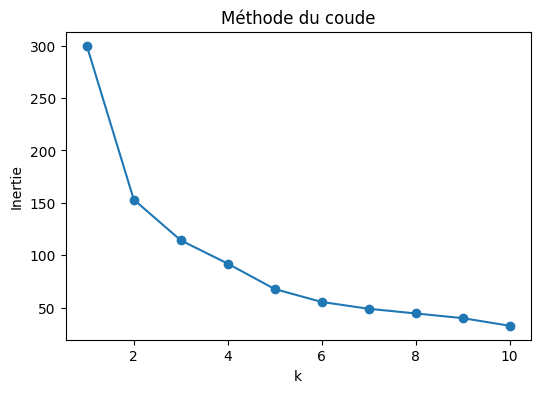

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from fonctions_kmeans import methode_coude
methode_coude(df1, ["G", "C", "D"])

In [50]:
k =3
X = df1[["G", "C", "D"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
km1 = KMeans(n_clusters=k, random_state=42)
df1["cluster"] = km1.fit_predict(X_scaled)
df1.groupby("cluster")[["G","C","D"]].mean()


,G,C,D
cluster,,,
0,0.302069,0.376043,0.321889
1,0.226460,0.290782,0.482758
2,0.285839,0.306272,0.407889


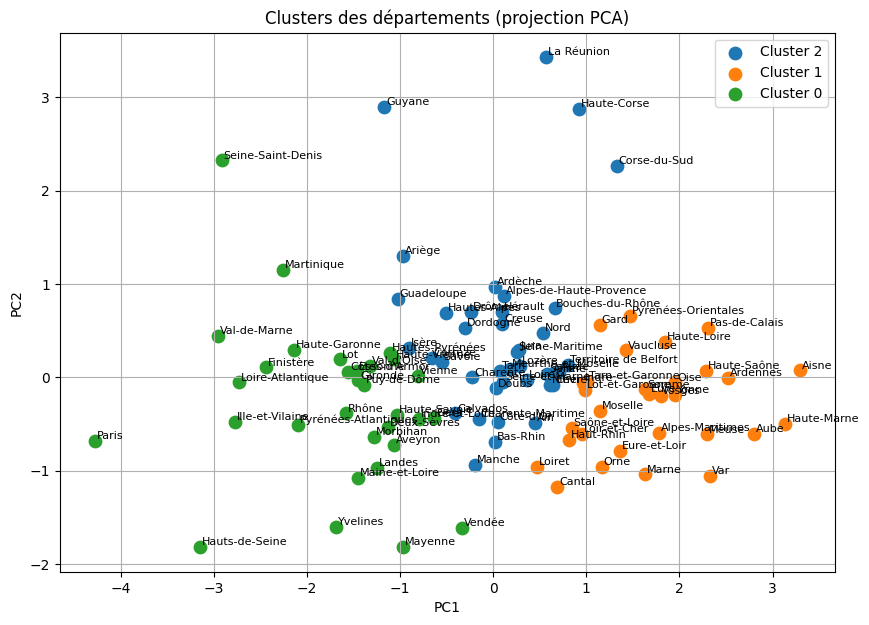

In [42]:
#  PCA pour projeter en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df1["PC1"] = X_pca[:, 0]
df1["PC2"] = X_pca[:, 1]

# Visualisation 
plt.figure(figsize=(10, 7))
for cluster in df1["cluster"].unique():
    subset = df1[df1["cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cluster}", s=80)

# Ajouter les labels (noms des départements)
for i in range(len(df1)):
    plt.text(df1["PC1"][i] + 0.02, df1["PC2"][i] + 0.02, df1["Dep"][i], fontsize=8)

plt.title("Clusters des départements (projection PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

Le clustering réalisé sur les scores des partis (regroupés en trois blocs : gauche, centre et droite) met en évidence trois profils électoraux distincts.
Le cluster 1 se caractérise par une nette domination du bloc de droite (48 %), ce qui renvoie à des départements plus conservateurs et davantage orientés vers les partis souverainistes ou libéraux-conservateurs.
Le cluster 2 montre également un avantage de la droite (41 %), mais dans une mesure moins marquée, suggérant un profil centre-droit modéré.
Enfin, le cluster 0 présente un équilibre gauche/droite, mais avec une domination du centre (38 %)

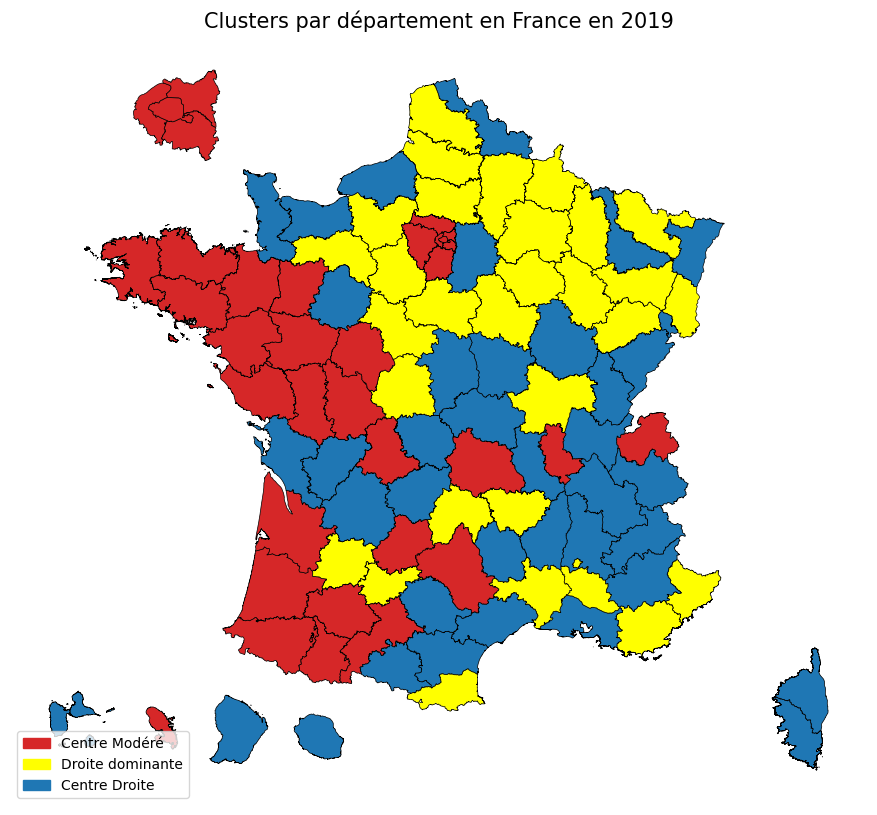

In [44]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

!pip install cartiflette
from cartiflette import carti_download

departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# clusters doit avoir une colonne "Dep" avec le nom des départements
df = df1[["Dep", "cluster"]]
    
departements_lambert93 = departements.to_crs(epsg=2154)
merged_geo_df = departements_lambert93.set_index('LIBELLE_DEPARTEMENT').join(df.set_index('Dep'))

political_colors = {
    "Centre Modéré": '#d62728',  # Red
    "Droite dominante": '#FFFF00',  # Yellow
    "Centre Droite": '#1f77b4'   # Blue
}

cmap = mcolors.ListedColormap([political_colors[key] for key in political_colors])

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged_geo_df.plot(
    column="cluster",
    cmap=cmap,
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend=False

)
ax.set_axis_off()

ax.set_title('Clusters par département en France en 2019', fontsize=15)

legend_patches = [
    mpatches.Patch(color=political_colors[label], label=label)
    for label in political_colors
]
ax.legend(handles=legend_patches, loc='lower left', frameon=True)

plt.show()

On fait la meme chose pour le tableau des élections de 2024

In [21]:
#nb: il ne s'agit pas exactement du meme code que pour le tableau precendent car les stuctures des tableaux ne sont pas les memes.
ee2024_info = ee2024.iloc[:, :16]  
ee2024_parti= ee2024.iloc[:, 16:]

#Sachant qu'il ya des colonnes inutiles, on va juste se concentre sur le nom du parti et les infos sur le nbr de voix
cols_par_parti = 8
cols_utiles = [2,6] 

# on selectionne les colonnes correspondantes pour chaque partie 
cols_a_garder = []
for i in range(0, 304, cols_par_parti):
    cols_a_garder.extend([i + j for j in cols_utiles])

ee2024_parti_n = ee2024_parti.iloc[:, cols_a_garder]  #152 colonnes 

cols_pct = [col for col in ee2024_parti_n.columns if '%' in col ]
for col in cols_pct:
    ee2024_parti_n[col] = ee2024_parti_n[col].astype(str).str.replace('%','').str.replace(',','.').astype(float)  #on enleve les pourcentages à coté car ca limite l'analyse et on les transforme en float



/tmp/ipykernel_7160/2285435228.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ee2024_parti_n[col] = ee2024_parti_n[col].astype(str).str.replace('%','').str.replace(',','.').astype(float)  #on enleve les pourcentages à coté car ca limite l'analyse et on les transforme en float
/tmp/ipykernel_7160/2285435228.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ee2024_parti_n[col] = ee2024_parti_n[col].astype(str).str.replace('%','').str.replace(',','.').astype(float)  #on enleve les pourcentages à coté 

In [22]:
ee2024_p_d, recap_2024= selection_top_partis(ee2024_parti_n)
ee2024_p_df=chang_col(ee2024_p_d)

In [23]:
ee24p=pd.concat([ee2024_info.iloc[:,1] ,ee2024_p_df], axis=1)
ee24p


,Libellé département,"LA FRANCE FIERE, MENEE PAR MARION MARECHAL ET SOUTENUE PAR ÉRIC ZEMMOUR",LFI - UP,La FRANCE REVIENT,EUROPE ÉCOLOGIE,PARTI ANIMALISTE,BESOIN D'EUROPE,LA DROITE POUR FAIRE ENTENDRE LA VOIX DE LA FRANCE EN EUROPE,REVEIL EUR,AR,GAUCHE UNIE
0,Ain,5.98,7.48,36.53,4.91,1.87,14.57,7.57,11.60,2.12,1.66
1,Aisne,4.98,5.29,50.64,2.36,2.41,11.30,6.25,7.78,2.19,2.31
2,Allier,5.32,5.18,36.70,3.07,2.34,13.00,8.88,11.78,3.91,5.10
3,Alpes-de-Haute-Provence,5.77,8.54,36.30,5.27,1.96,12.08,4.18,13.63,3.64,2.95
4,Hautes-Alpes,5.69,7.66,31.06,7.42,1.86,14.06,5.50,15.52,3.33,2.36
...,...,...,...,...,...,...,...,...,...,...,...
102,Wallis et Futuna,9.98,8.61,18.63,3.91,0.86,26.60,10.12,6.07,2.01,2.33
103,Polynésie française,5.04,5.14,20.58,6.55,0.07,41.54,3.09,4.72,1.13,1.00
104,Nouvelle-Calédonie,16.01,4.01,21.71,3.51,0.15,28.64,12.66,4.17,0.91,0.49
105,Saint-Martin/Saint-Barthélemy,9.66,5.02,27.44,4.99,0.25,28.25,4.62,5.90,1.25,0.47


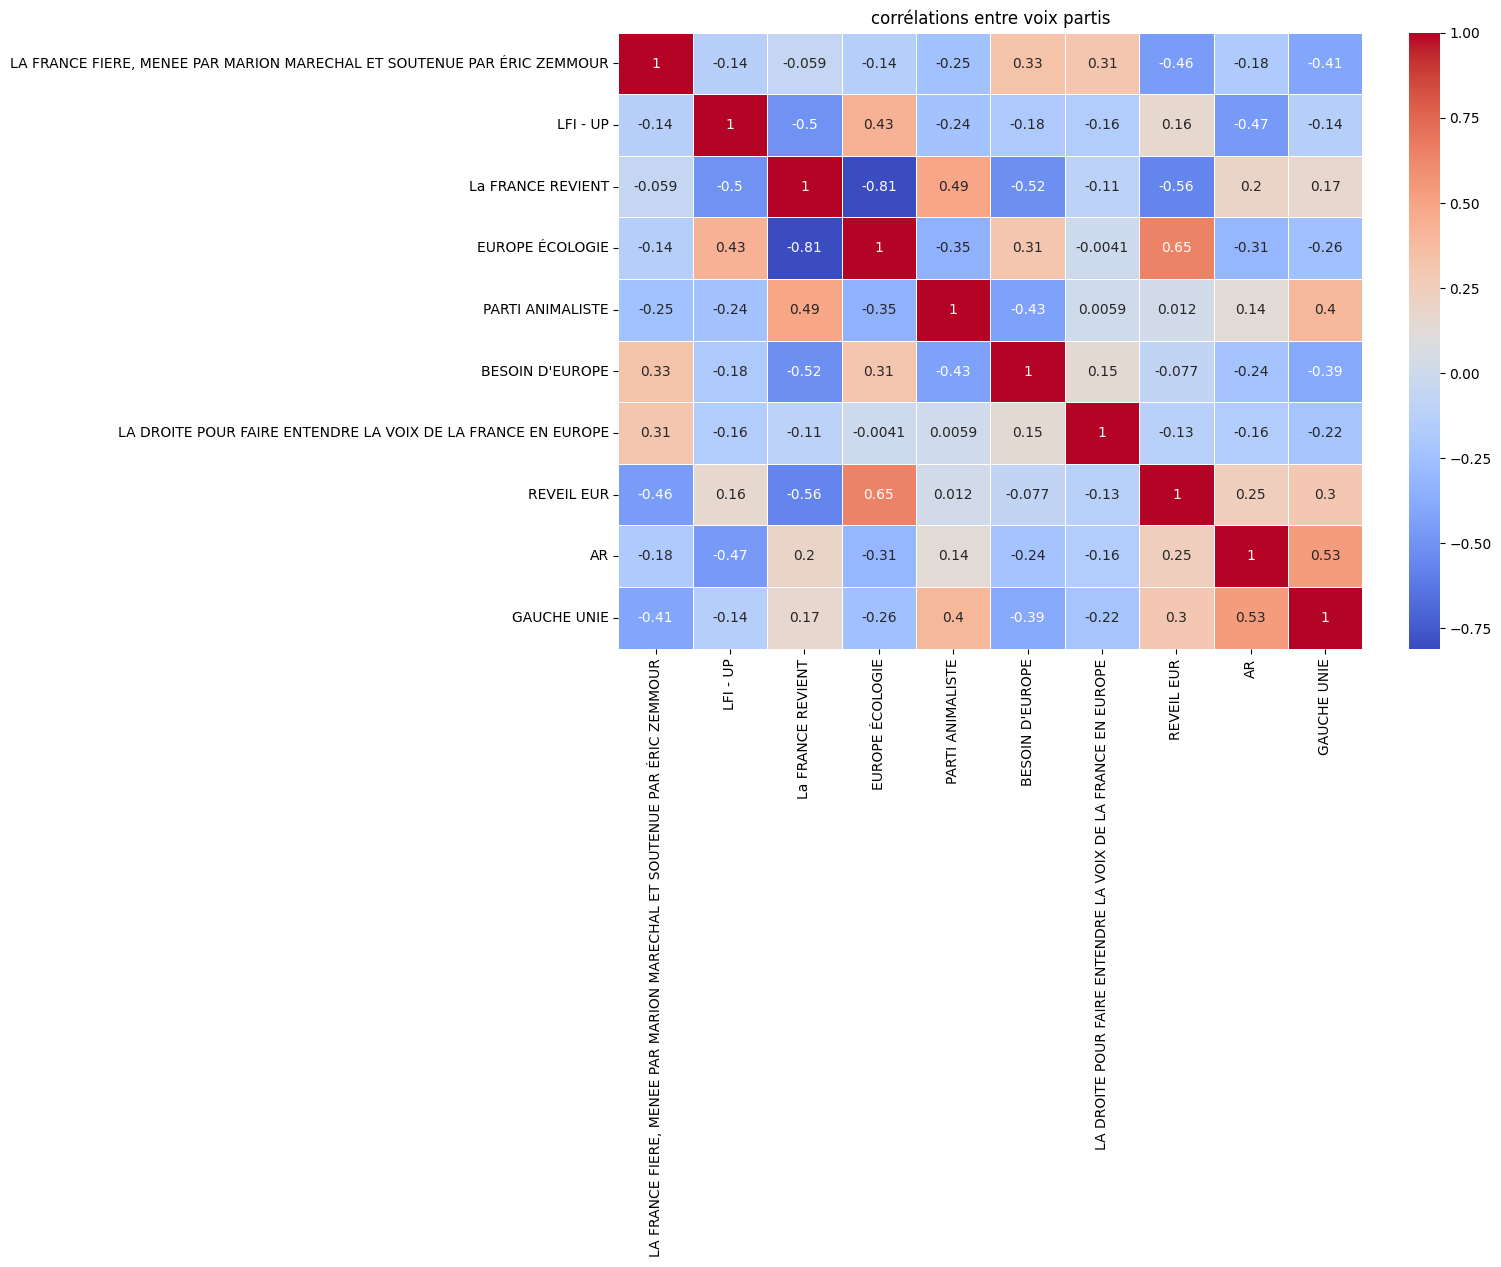

In [24]:
cor = ee2024_p_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("corrélations entre voix partis")
plt.show()


Le point le plus important est l'opposition totale entre La France Revient (RN) et Europe Écologie (−0,81). Cela signifie que leurs électorats sont géographiquement et socialement à l'opposé.
On remarque aussi qu'il existe une cohérence entre la Gauche Unie et la liste AR (0,53), montrant un bloc de gauche qui reste groupé sur certains territoires.
L'extrême droite (La France Fière) se distingue en ayant quelques points communs avec la droite classique et la majorité présidentielle (Besoin d'Europe), mais il reste très éloigné des votes écologistes ou de la gauche radicale.
Enfin, on remarque que la liste LFI - UP est en opposition avec presque tout le monde sauf les écologiques, notamment avec le RN (−0,50) et la majorité présidentielle (−0,47).

In [27]:
ee2024_p_df.describe()

,"LA FRANCE FIERE, MENEE PAR MARION MARECHAL ET SOUTENUE PAR ÉRIC ZEMMOUR",LFI - UP,La FRANCE REVIENT,EUROPE ÉCOLOGIE,PARTI ANIMALISTE,BESOIN D'EUROPE,LA DROITE POUR FAIRE ENTENDRE LA VOIX DE LA FRANCE EN EUROPE,REVEIL EUR,AR,GAUCHE UNIE
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,5.541308,8.568505,33.148037,4.942243,1.904299,14.688879,7.068037,13.038692,2.961869,2.415607
std,1.557791,4.741415,8.250428,1.743441,0.596507,4.369097,1.927399,3.583462,1.835015,0.845411
min,2.350000,3.740000,8.300000,2.170000,0.030000,6.430000,3.020000,2.530000,0.380000,0.470000
25%,4.850000,5.835000,28.725000,3.710000,1.770000,12.395000,6.025000,10.715000,1.690000,1.935000
50%,5.330000,7.330000,33.670000,4.670000,1.980000,13.780000,6.870000,12.940000,2.490000,2.340000
75%,5.760000,9.120000,37.970000,5.825000,2.260000,15.580000,7.965000,15.440000,3.630000,2.840000
max,16.010000,37.130000,52.420000,12.180000,2.840000,41.540000,13.300000,22.860000,8.390000,5.100000


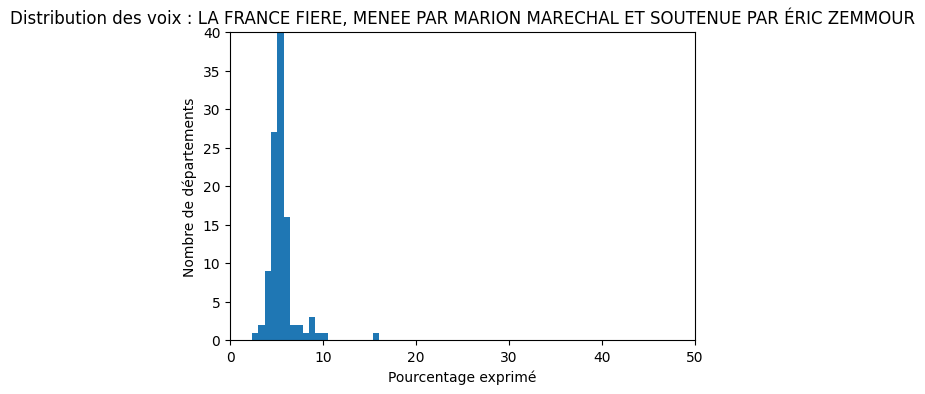

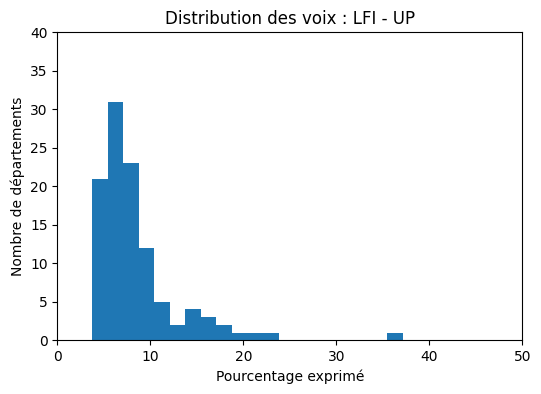

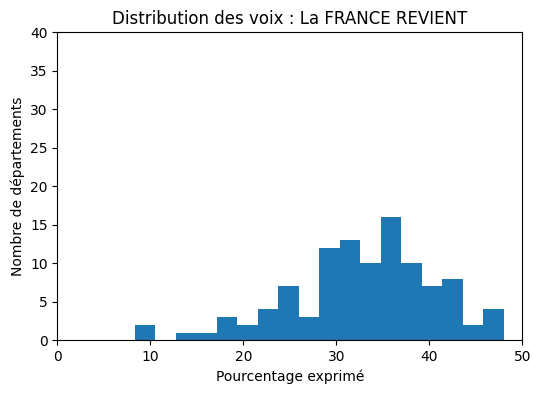

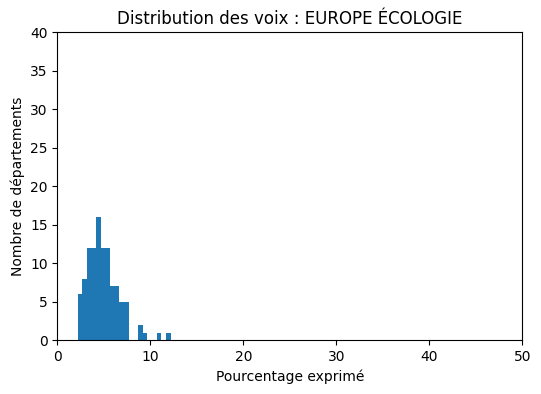

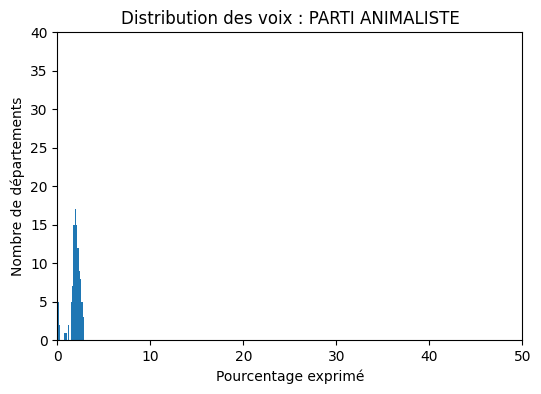

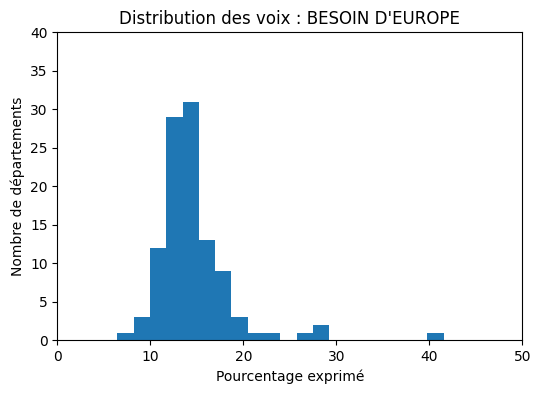

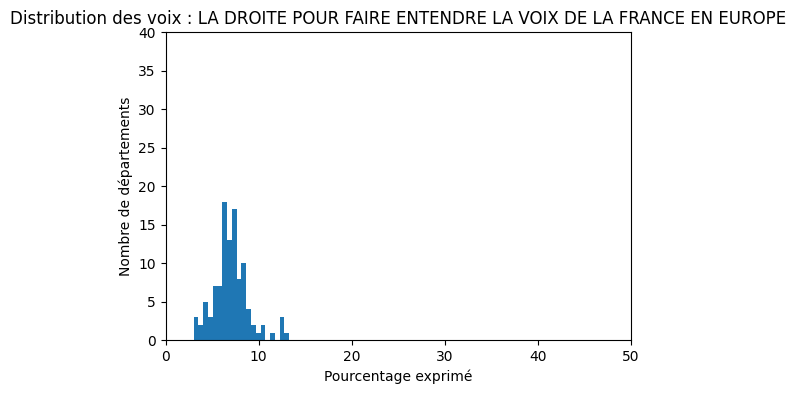

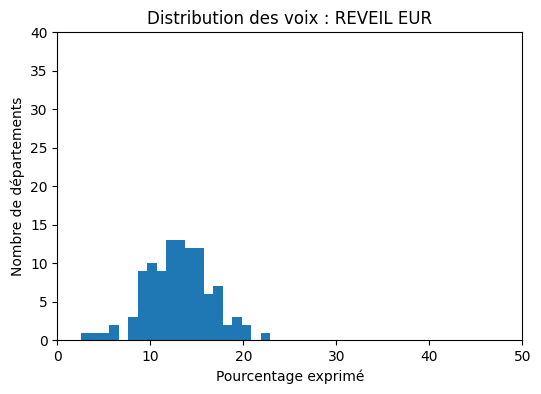

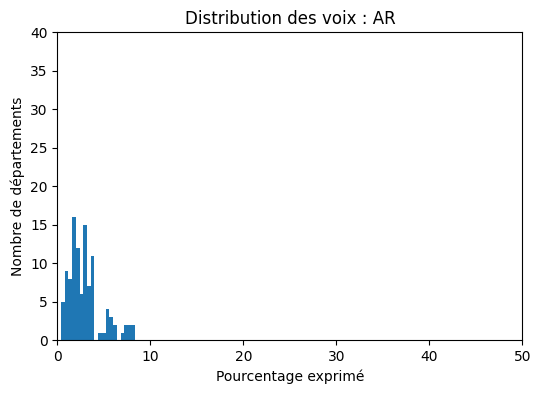

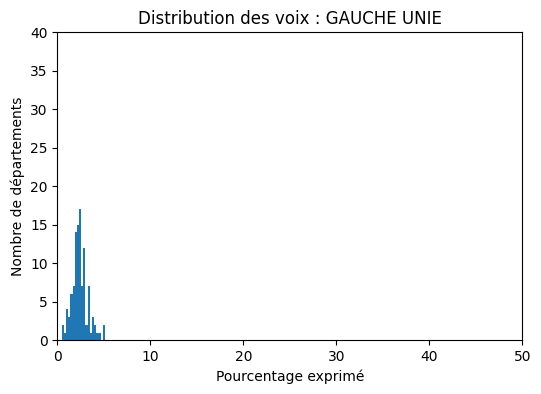

In [30]:
for col in ee2024_p_df.columns:
    plt.figure(figsize=(6,4))
    plt.xlim(0,50)
    plt.ylim(0,40)
    plt.hist(ee2024_p_df[col], bins=20)
    plt.title(f"Distribution des voix : {col}")
    plt.xlabel("Pourcentage exprimé")
    plt.ylabel("Nombre de départements")
    plt.show()

On constate que 'LA FRANCE REVIENT' domine de loin avec une moyenne de votes de 33% et un histogramme complètement à droite contrairement aux autres partis.

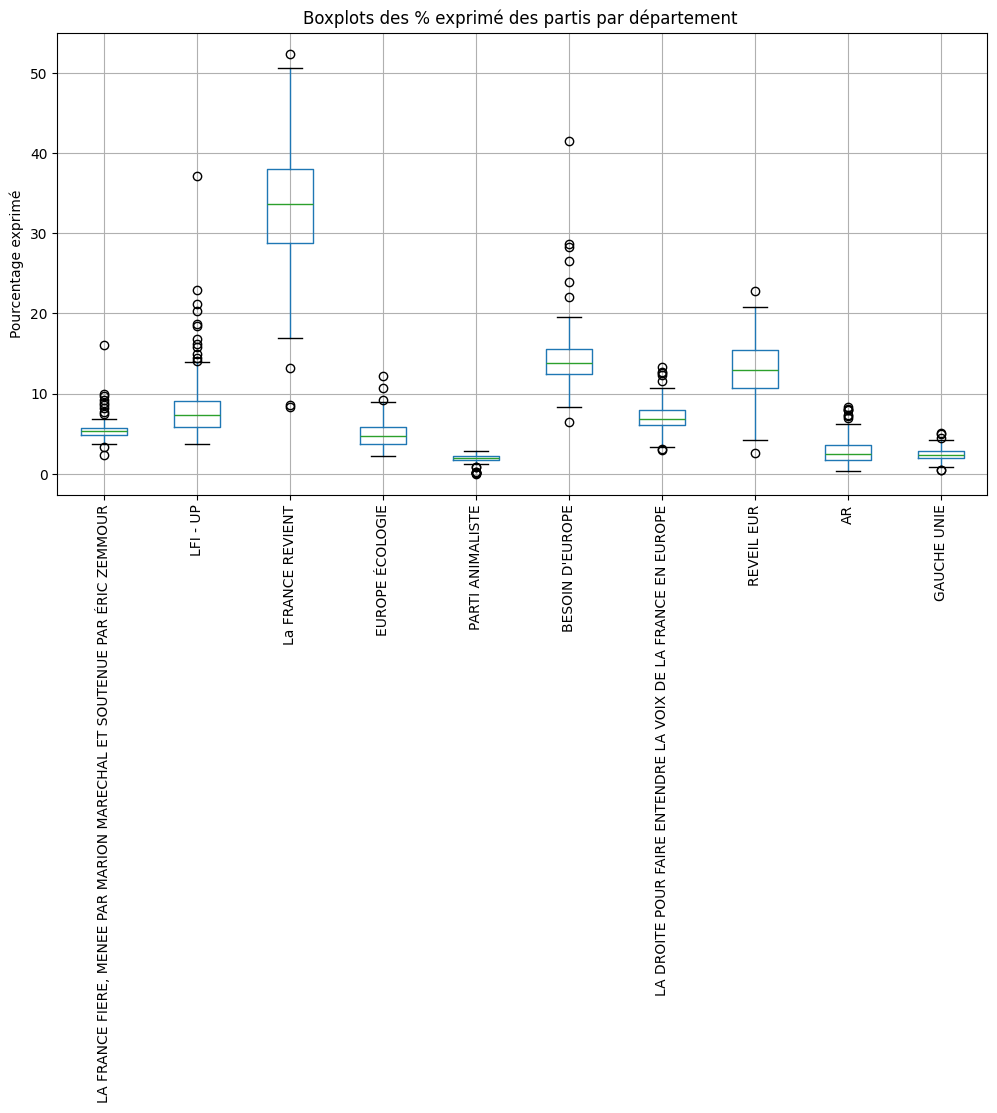

In [31]:
plt.figure(figsize=(12,6))
ee2024_p_df.boxplot(rot=90)
plt.title("Boxplots des % exprimé des partis par département ")
plt.ylabel("Pourcentage exprimé")
plt.show()

'LA FRANCE REVIENT' domine largement le scrutin avec une médiane s'élevant à environ 34 % et une dispersion très importante, atteignant un pic exceptionnel au-delà de 50 % dans certains départements. En retrait, les listes 'BESOIN D'EUROPE' et 'REVEIL EUR' se disputent la deuxième place avec des médianes proches de 14-15 %, bien que la première affiche une plus grande hétérogénéité territoriale marquée par plusieurs valeurs atypiques élevées. Les autres formations, telles que 'LFI - UP', 'LA FRANCE FIERE' ou 'EUROPE ÉCOLOGIE', se situent dans un mouchoir de poche avec des scores médians oscillant entre 5 % et 8 %, tandis que le 'PARTI ANIMALISTE' et la 'GAUCHE UNIE' ferment la marche avec des résultats très faibles et une quasi-absence de variation géographique. 

In [25]:
gauche2= ["LFI - UP","GAUCHE UNIE","PARTI ANIMALISTE","EUROPE ÉCOLOGIE", "AR"]
droite2= ["La FRANCE REVIENT","LA DROITE POUR FAIRE ENTENDRE LA VOIX DE LA FRANCE EN EUROPE","LA FRANCE FIERE, MENEE PAR MARION MARECHAL ET SOUTENUE PAR ÉRIC ZEMMOUR"]
centre2=["BESOIN D'EUROPE","REVEIL EUR"]
G2= ee24p[gauche2].sum(axis=1)
D2=ee24p[droite2].sum(axis=1)
C2=ee24p[centre2].sum(axis=1)
total_pd24=G2+D2+C2

bord_pol24=pd.DataFrame({
    "Dep":ee24p.iloc[:,0],
    "G": G2/total_pd24,
    "C": C2/total_pd24,
    "D": D2/total_pd24,
}) 

voix_bpf24= bord_pol24.iloc[:100,:]
#on reduit a 100 car les autres tableaux n'incluent pas les collectivites d'outre mer

In [33]:
voix_bpf24

,Dep,G,C,D
0,Ain,0.191325,0.277548,0.531127
1,Aisne,0.152445,0.199770,0.647786
2,Allier,0.205709,0.260076,0.534215
3,Alpes-de-Haute-Provence,0.237065,0.272583,0.490352
4,Hautes-Alpes,0.239572,0.313148,0.447279
...,...,...,...,...
95,Val-d'Oise,0.346725,0.258215,0.395060
96,Guadeloupe,0.258480,0.322985,0.418535
97,Martinique,0.313748,0.379122,0.307131
98,Guyane,0.351184,0.245806,0.403011


In [45]:
voix_bpf24.to_csv("ee_bp24.csv",index=False)

Definition des clusters 2024

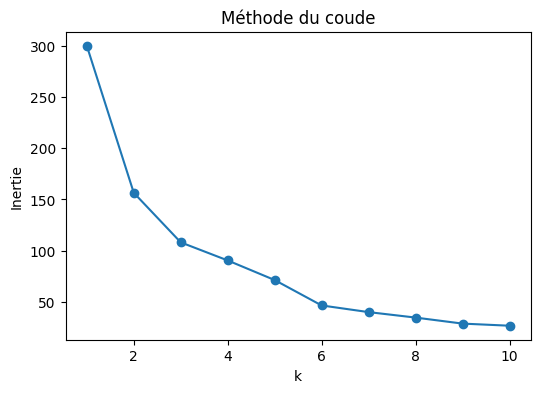

In [51]:
df2= pd.read_csv("ee_bp24.csv")
methode_coude(df2, ["G", "C", "D"])

In [54]:
k =3
X = df2[["G", "C", "D"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
km2 = KMeans(n_clusters=k, random_state=42)
df2["cluster"] = km2.fit_predict(X_scaled)
df2.groupby("cluster")[["G","C","D"]].mean()

,G,C,D
cluster,,,
0,0.238710,0.344445,0.416845
1,0.200751,0.260968,0.538281
2,0.380258,0.249729,0.370013


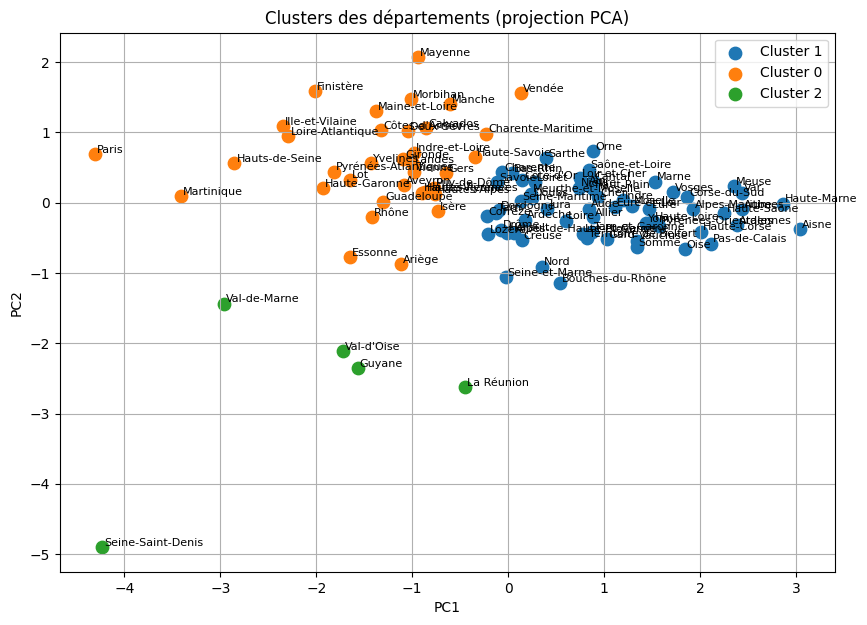

In [55]:
#PCA pour projeter en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df2["PC1"] = X_pca[:, 0]
df2["PC2"] = X_pca[:, 1]

# Visualisation 
plt.figure(figsize=(10, 7))
for cluster in df2["cluster"].unique():
    subset = df2[df2["cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cluster}", s=80)

# Ajouter les labels (noms des départements)
for i in range(len(df2)):
    plt.text(df2["PC1"][i] + 0.02, df2["PC2"][i] + 0.02, df2["Dep"][i], fontsize=8)

plt.title("Clusters des départements (projection PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

Le clustering réalisé sur les résultats électoraux permet d’identifier trois profils politiques distincts de départements : un cluster dominé par la droite, un cluster marqué par un vote de gauche plus élevé mais avec presence de la droite et un cluster intermédiaire à dominante centriste-droite.

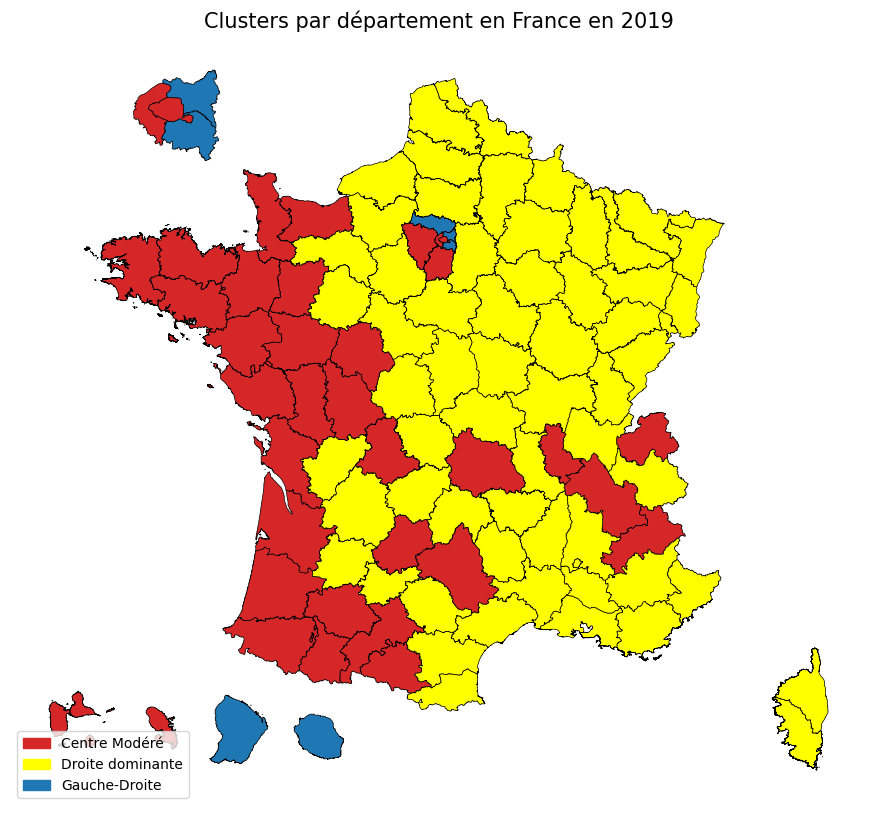

In [58]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

!pip install cartiflette
from cartiflette import carti_download

departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# clusters doit avoir une colonne "Dep" avec le nom des départements
df = df2[["Dep", "cluster"]]
    
departements_lambert93 = departements.to_crs(epsg=2154)
merged_geo_df = departements_lambert93.set_index('LIBELLE_DEPARTEMENT').join(df.set_index('Dep'))

political_colors = {
    "Centre Modéré": '#d62728',  # Red
    "Droite dominante": '#FFFF00',  # Yellow
    "Gauche-Droite": '#1f77b4'   # Blue
}

cmap = mcolors.ListedColormap([political_colors[key] for key in political_colors])

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged_geo_df.plot(
    column="cluster",
    cmap=cmap,
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend=False

)
ax.set_axis_off()

ax.set_title('Clusters par département en France en 2019', fontsize=15)

legend_patches = [
    mpatches.Patch(color=political_colors[label], label=label)
    for label in political_colors
]
ax.legend(handles=legend_patches, loc='lower left', frameon=True)

plt.show()

Il ya une montée excepetionelle du vote à droite dans l'est et le centre du pays.
Meme si les zones de l'ouest votent toujours au centre, le vote à droite augmente aussi de leur coté.

Pourquoi autant de vote à Droite?
La victoire massive de la droite s'explique par un vote de sanction contre Emmanuel Macron et une forte inquiétude sur le pouvoir d'achat. Le RN a réussi à sortir de ses zones habituelles pour convaincre de nouveaux électeurs comme les retraités et les cadres, tout en captant le sentiment d'abandon des habitants des zones rurales.

# 2/ 


# 3/